# Exploring Candidate Classification with ML

In this notebook, we show how we have built our Candidate classifier.

In [21]:
%matplotlib inline
from Politweet import get_tweets
import pandas as pd
pd.set_option('display.max_colwidth', 1200)

# Get the tweets
tweets = get_tweets("./datasets/tweets.tsv")

## Choosing data for training

For train and test, we decide to build a training set from the tweets. The assumption is that all the tweets that are not rated 'OTHER' (hence unrelated) and that mention either Obama or McCain. In this way, we can label a set of tweets based on this heuristics, so that we can learn weights for words and use those to classify other tweets that may not mention Obama or McCain directly, but that refer to them.

In [22]:
import re
import ratings
from sklearn.cross_validation import train_test_split
from Politweet import df_setminus

def prepare_sentiment_data(tweets):
    obama = tweets[tweets["content"].str.contains('obama', flags=re.IGNORECASE)]
    mccain = tweets[tweets["content"].str.contains('mccain', flags=re.IGNORECASE)]
    oba_and_mccain = tweets.reindex(obama.index & mccain.index)
    oba_or_mccain = tweets.reindex(obama.index | mccain.index)
    none = tweets[~(tweets["content"].str.contains('obama|mccain', flags=re.IGNORECASE))]
    other = ratings.all(tweets, ratings.OTHER)

    only_mccain = df_setminus(mccain, oba_and_mccain)
    only_obama = df_setminus(obama, oba_and_mccain)
    other_none = df_setminus(df_setminus(other, oba_or_mccain), oba_and_mccain)

    oba = [
        (t, 'oba')
        for i,t in only_obama.iterrows()]

    mcc = [
        (t, 'mcc')
        for i,t in only_mccain.iterrows()]

    both = [
        (t, 'both')
        for i,t in oba_and_mccain.iterrows()]

    other = [
        (t, 'none')
        for i,t in other_none.iterrows()]
    print len(oba+mcc+both+other)

    train, test = train_test_split(
        oba + mcc + both + other, 
        test_size = .2, 
        random_state = 20)

    return train, test

#### Make sure data is tokenized

We make sure that we use our pre-processed tokenization for each tweet

In [23]:
def featurize(tweet):
    tokens = [token['lemma'] for token in tweet['clean'] if token['lemma'] != '']
    return tokens

#### Running a pipeline
The strategy is to use the pipeline design pattern.
We input data to the pipeline and this will run the pipeline, hence vectorize our input and pass it to the classifier.

In [24]:
from sklearn.metrics import classification_report

def run_pipeline(train, test, clsfr):
    # fit the classifier with training data
    train_x, train_y = zip(*train)
    test_x, test_y = zip(*test)
    clsfr.fit(train_x, train_y)
    # get accuracy on the test
    scr = classification_report(clsfr.predict(test_x), test_y)
    return scr

## TF-IDF + Candidate rules classifier (pipeline)

#### Rule Based features
This matches Obama or McCain in tweets and adds a new entry candidate(Obama) or candidate(McCain) if encountred. Engineering this feature is going to help us to get 100% accuracy on twits that have this pattern.

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

obama_regex = re.compile(".*(obama|barack).*")
mccain_regex = re.compile(".*(mccain|mcpain|).*")

class RuleBasedCandidate(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def featurize(self, document):
        document_words = set(document["tokens"])
        features = {}
        features['candidate(obama)'] = not not obama_regex.match(document["content"])
        features['candidate(mccain)'] = not not mccain_regex.match(document["content"])
        return features

    def transform(self, docs):
        return [self.featurize(d) for d in docs]

Hence, our pipeline will combine two feature vectors. The first is the TFIDF score of each word in a tweet; the second one will run our rule based system, and give a binary vector of matched candidates.

In [26]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipeline_candidates = Pipeline([
    ('features', FeatureUnion([
        ('ngram_tf_id', Pipeline([
            ('count', CountVectorizer(tokenizer = featurize, lowercase=False)),
            ('tf_id', TfidfTransformer())
        ])),
        ('rule_based_syste', Pipeline([
                ('match', RuleBasedCandidate()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ]))
    ])),
    ('classifier', LinearSVC())
])

## Results

In order to evaluate our system, we report precision, recall, f1-score and support for all classes and their average. In addition, we show a confusion matrix that highlights false positive and negatives.

In [31]:
from sklearn.metrics import classification_report

train, test = prepare_sentiment_data(tweets)
run_pipeline(train, test, pipeline_candidates)
test_x, test_y = zip(*test)

1923


In [32]:
from sklearn.metrics import classification_report
print classification_report(pipeline_candidates.predict(test_x), test_y)

             precision    recall  f1-score   support

       both       0.89      0.96      0.92        89
        mcc       0.95      0.88      0.91       151
       none       0.38      1.00      0.55         9
        oba       0.99      0.91      0.95       136

avg / total       0.94      0.91      0.92       385



[[ 85   4   0   0]
 [  5 133  12   1]
 [  0   0   9   0]
 [  6   3   3 124]]


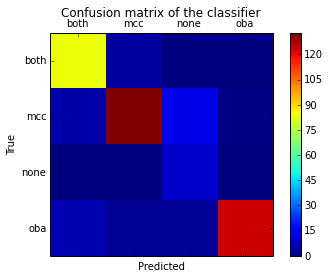

In [33]:
import pylab as plt
from sklearn.metrics import confusion_matrix

labels = ['both', 'mcc', 'none', 'oba']
cm = confusion_matrix(pipeline_candidates.predict(test_x), test_y)

print cm

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Predicting and annotating tweets

Finally, for the purpose of the visualization, we predict and annotate all the tweets.

In [30]:
def df_candidates(tweets):
    tweets["candidate"] = pd.Series(pipeline_candidates.predict([t for i,t in tweets.iterrows()]), index=tweets.index)
    return tweets

df_candidates(tweets)[["content", "candidate"]][:2]

,content,candidate
tweet.id,,
936469851,Watching by myself #tweetdebate Not drinking :( waiting to start cringing at McCain blunders,mcc
936470432,"@ahg3 @MichDot Yeah, slime was actually my second choice, can't say what the first one was. Okay, we're rolling...",mcc
